## Import Modules

In [1]:
import nltk
import random
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from nltk.classify import ClassifierI
from statistics import mode
from nltk.tokenize import word_tokenize
import re
import os

import csv
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline

import nltk.data;
from gensim.models import word2vec;
from sklearn.cluster import KMeans;
from sklearn.neighbors import KDTree;
import pandas as pd;
import numpy as np;
import os;
import re;
import logging;
import sqlite3;
import time;
import sys;
import multiprocessing;
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt;
from itertools import cycle;

In [3]:
# !pip install wordcloud

In [4]:
from nltk.corpus.reader import WordListCorpusReader
from nltk.corpus.reader.api import *
nltk.download('opinion_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import opinion_lexicon
from nltk.corpus import stopwords

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/tyler/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/tyler/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tyler/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tyler/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
from tqdm import tqdm
import numpy as np
from collections import defaultdict

# load lexicons

In [6]:
#helper function 
def txt_to_csv(txt_file,new_csv_file, header=int):
    # use 'with' if the program isn't going to immediately terminate
    # so you don't leave files open
    # the 'b' is necessary on Windows
    # it prevents \x1a, Ctrl-z, from ending the stream prematurely
    # and also stops Python converting to / from different line terminators
    # On other platforms, it has no effect
    in_txt = csv.reader(open(txt_file, "r"), delimiter = '\t')
    out_csv = csv.writer(open(new_csv_file, 'w'))

    out_csv.writerows(in_txt)
    
    lex_csv = pd.read_csv(str(new_csv_file),header=header)
    
    return lex_csv

In [7]:
#setup vars for VAD lexicon load
vad_text_file = r"./data/NRC-VAD-Lexicon.txt"
vad_csv_file = r"vad_lex.csv"

In [8]:
vad_lex = txt_to_csv(vad_text_file, vad_csv_file, header=0)

In [9]:
vad_lex.head()

,Word,Valence,Arousal,Dominance
0,aaaaaaah,0.479,0.606,0.291
1,aaaah,0.520,0.636,0.282
2,aardvark,0.427,0.490,0.437
3,aback,0.385,0.407,0.288
4,abacus,0.510,0.276,0.485


In [10]:
# for i in range(len(vad_lex['Word'])):
#     print(vad_lex['Word'][i])

In [11]:
#nltk opinion lexicon
pos_lex = opinion_lexicon.positive()
neg_lex = opinion_lexicon.negative()

## load in pre-processed confessions

In [12]:
import pandas as pd
path = '/Users/tyler/UCSD_Wellness/analysis/data/data1.csv'
confessions=pd.read_csv(path)

In [13]:
# confessions.head()

## Function for further pre-processing of confessions


In [14]:
def clean_text(all_comments, out_name):
    
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle');
    
    stop_words = list(set(stopwords.words('english')))
    
    out_file = open(out_name, 'w');
    
    for pos in range(len(all_comments)):
        
        #Get the comment
        val = all_comments.iloc[pos];
        
        #Normalize tabs and remove newlines
        no_tabs = str(val).replace('\t', ' ').replace('\n', '');
        
        #Remove all characters except A-Z and a dot.
        alphas_only = re.sub("[^a-zA-Z\.]", " ", no_tabs);
        
        #Remove punctuation
        no_punc = re.sub(r'[^(a-zA-Z)\s]','', alphas_only)
        
        #Normalize spaces to 1
        multi_spaces = re.sub(" +", " ", no_punc);
        
        #Strip trailing and leading spaces
        no_spaces = multi_spaces.strip();
        
        #Normalize all charachters to lowercase
        clean_text = no_spaces.lower();
        
        #Get sentences from the tokenizer, remove the dot in each.
        sentences = tokenizer.tokenize(clean_text);
        
        stopped = [w for w in sentences if not w in stop_words]
        
        sentences = [re.sub("[\.]", "", sentence) for sentence in sentences];
        
        #If the text has more than one space (removing single word comments) and one character, write it to the file.
        out_file.write("%s\n" % sentences)
                
                
        #Simple logging. At every 50000th step,
        #print the total number of rows processed and time taken so far, and flush the file.
#         if pos % 50000 == 0:
#             total_time = time.time() - start;
# #             sys.stdout.write('Completed ' + str(round(100 * (pos / total_rows), 2)) + '% - ' + str(pos) + ' rows in time ' + str(round(total_time / 60, 0)) + ' min & ' + str(round(total_time % 60, 2)) + ' secs\r');
#             out_file.flush();
#             break;
        
    out_file.close();

## Add date-time info to original confessions dataframe

In [15]:
confessions['timestamp']=pd.to_datetime(confessions.timestamp)
confessions['weekday']=confessions.timestamp.dt.strftime('%a')
confessions['weekday']=pd.Categorical(confessions['weekday'],categories=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],ordered=True)

confessions.head()

,id,timestamp,content,contact,tags,note,weekday
0,14442,2019-10-12 17:05:24,I’m super excited for homecoming next weekend ...,NaN,NaN,NaN,Sat
1,14441,2019-10-12 13:22:03,"If I never met you, I would never have gotten ...",NaN,serious,NaN,Sat
2,14440,2019-10-11 17:03:50,There is an abnormal amount of hot girls that ...,NaN,NaN,NaN,Fri
3,14439,2019-10-11 15:58:00,"Just out of curiosity, on a scale of one to te...",NaN,NaN,NaN,Fri
4,14438,2019-10-10 19:10:20,To the person who was playing the trumpet outs...,NaN,wholesome,NaN,Thu


In [16]:
start = time.time();
clean_comments = clean_text(confessions['content'], './data/extra_clean_comments.txt')
print('Total time: ' + str((time.time() - start)) + ' secs')

Total time: 0.7964329719543457 secs


In [17]:
extra_clean_txt_file = r"./data/extra_clean_comments.txt"
extra_clean_csv_file = r"extra_clean_comments.csv"

In [18]:
clean_confessions = txt_to_csv(extra_clean_txt_file, extra_clean_csv_file, header=None)
# print(clean_comments)
clean_content = clean_confessions[0].tolist()
# len(clean_content)

## Construct Various Sentiment Scoring Dictionaries

### nltk opinion positive/negative lexicon

#### This takes a long time to compute, so saved & loaded as a pkl file.

In [19]:
# pn_lex_score = defaultdict(int)
# for i,note in tqdm(enumerate(clean_content)):
#     pn_lex_score[i] = np.array([0.,0.])
#     note = re.sub("[^\w]", " ",  note).split()
#     for word in note:
#         if word in pos_lex:
#             pn_lex_score[i] += np.array([1.,0.])
#         elif word in neg_lex:
#             pn_lex_score[i] += np.array([0.,1.])

In [20]:
# output = open('pn_lex_score.pkl', 'wb')
# pickle.dump(pn_lex_score, output)
# output.close()

In [21]:
pkl_file = open('pn_lex_score.pkl', 'rb')
pn_lex_score = pickle.load(pkl_file)
pkl_file.close()

In [22]:
temp = pd.DataFrame.from_dict(pn_lex_score, orient='index', columns=['#POS', '#NEG'])
new_1 = pd.concat([confessions,temp],axis=1)

### NRC VAD Lexicon

In [23]:
# #NRC VAD lexicon
# all_VAD_scores = defaultdict(int)
# # clean_content = clean_comments[0].tolist()
# for i,note in tqdm(enumerate(clean_content)):
#     all_VAD_scores[i] = np.array([0.,0.,0.])
#     note = re.sub("[^\w]", " ",  note).split()
#     for word in note:
#         if word in list(vad_lex['Word']):
#             all_VAD_scores[i] += np.array([vad_lex['Valence'][i],vad_lex['Arousal'][i],vad_lex['Dominance'][i]])

In [24]:
# output = open('all_VAD_scores.pkl', 'wb')
# pickle.dump(all_VAD_scores, output)
# output.close()

In [25]:
pkl_file = open('all_VAD_scores.pkl', 'rb')
all_VAD_scores = pickle.load(pkl_file)
pkl_file.close()

In [26]:
# all_VAD_scores

In [27]:
# test = confessions

In [28]:
temp_VAD = pd.DataFrame.from_dict(all_VAD_scores, orient='index', columns=['Valence','Arousal','Dominance'])

In [29]:
new = pd.concat([new_1,temp_VAD],axis=1)

In [30]:
new.head()

,id,timestamp,content,contact,tags,note,weekday,#POS,#NEG,Valence,Arousal,Dominance
0,14442,2019-10-12 17:05:24,I’m super excited for homecoming next weekend ...,NaN,NaN,NaN,Sat,6.0,1.0,12.933,16.362,7.857
1,14441,2019-10-12 13:22:03,"If I never met you, I would never have gotten ...",NaN,serious,NaN,Sat,4.0,6.0,28.600,34.980,15.510
2,14440,2019-10-11 17:03:50,There is an abnormal amount of hot girls that ...,NaN,NaN,NaN,Fri,3.0,1.0,4.270,4.900,4.370
3,14439,2019-10-11 15:58:00,"Just out of curiosity, on a scale of one to te...",NaN,NaN,NaN,Fri,0.0,0.0,3.080,3.256,2.304
4,14438,2019-10-10 19:10:20,To the person who was playing the trumpet outs...,NaN,wholesome,NaN,Thu,3.0,0.0,5.610,3.036,5.335


# Graphing VAD frequency across weekday

In [31]:
# calculate total scores and counts
weekday_valence_sum=new.groupby('weekday')['Valence'].sum()
weekday_valence_count=new.groupby('weekday')['Valence'].count()
valence = weekday_valence_sum/weekday_valence_count

weekday_arousal_sum=new.groupby('weekday')['Arousal'].sum()
weekday_arousal_count=new.groupby('weekday')['Arousal'].count()
arousal = weekday_arousal_sum/weekday_arousal_count

weekday_dominance_sum=new.groupby('weekday')['Dominance'].sum()
weekday_dominance_count=new.groupby('weekday')['Dominance'].count()
dominance = weekday_dominance_sum/weekday_dominance_count



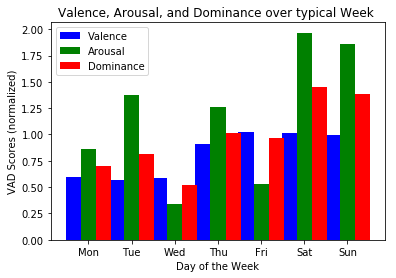

In [32]:
fig, ax = plt.subplots()
index = np.arange(7)
bar_width =0.5
w = 0.35
ax.bar(index-w, valence.values-10, width=w, color='b', align='center',label="Valence")
ax.bar(index, arousal.values-10, width=w, color='g', align='center', label="Arousal")
ax.bar(index+w, dominance.values-10, width=w, color='r', align='center', label="Dominance")
# ax.bar(list(weekday_distri.index))
# plt.bar(index, weekday_valence.values)
# plt.bar(index+bar_width, weekday_arousal.values)
# plt.bar(index+bar_width*2, weekday_dominance.values)
# ax.set(xlabel='weekday', ylabel='VAD score')
ax.grid(False)
plt.ylabel("VAD Scores (normalized)")
plt.xlabel("Day of the Week")
plt.xticks(index,list(weekday_valence_sum.index))
plt.legend()
plt.title('Valence, Arousal, and Dominance over typical Week ')
fig.savefig("weekday.png")
plt.show()

# NLTK Polarity Analysis

In [33]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [34]:
# next, we initialize VADER so we can use it within our Python script
sid = SentimentIntensityAnalyzer()

# the variable 'message_text' now contains the text we will analyze.
message_text = '''Like you, I am getting very frustrated with this process. I am genuinely trying to be as reasonable as possible. I am not trying to "hold up" the deal at the last minute. I'm afraid that I am being asked to take a fairly large leap of faith after this company (I don't mean the two of you -- I mean Enron) has screwed me and the people who work for me.'''

print(message_text)

# Calling the polarity_scores method on sid and passing in the message_text outputs a dictionary with negative, neutral, positive, and compound scores for the input text
scores = sid.polarity_scores(message_text)

# Here we loop through the keys contained in scores (pos, neu, neg, and compound scores) and print the key-value pairs on the screen

for key in sorted(scores):
        print('{0}: {1}, '.format(key, scores[key]), end='')

Like you, I am getting very frustrated with this process. I am genuinely trying to be as reasonable as possible. I am not trying to "hold up" the deal at the last minute. I'm afraid that I am being asked to take a fairly large leap of faith after this company (I don't mean the two of you -- I mean Enron) has screwed me and the people who work for me.
compound: -0.3804, neg: 0.093, neu: 0.836, pos: 0.071, 

In [35]:
# # next, we initialize VADER so we can use it within our Python script
# sid = SentimentIntensityAnalyzer()

# all_nltk_vader_scores = defaultdict(int)
# # clean_content = clean_comments[0].tolist()
# for i,note in tqdm(enumerate(clean_content)):
#     scores = sid.polarity_scores(note)
#     all_nltk_vader_scores[i] = np.array([scores['neg'],scores['neu'],scores['pos'],scores['compound']])
    

In [36]:
# output = open('all_nltk_vader_scores.pkl', 'wb')
# pickle.dump(all_nltk_vader_scores, output)
# output.close()

In [37]:
pkl_file = open('all_nltk_vader_scores.pkl', 'rb')
all_nltk_vader_scores = pickle.load(pkl_file)
pkl_file.close()

In [38]:
nltk_vader = pd.DataFrame.from_dict(all_nltk_vader_scores, orient='index', columns=['neg','neu','pos','compound'])
nltk_vader.head()
df = pd.concat([new,nltk_vader],axis=1)

In [39]:
df['hour']=confessions.timestamp.dt.strftime('%H')
df.head()

,id,timestamp,content,contact,tags,note,weekday,#POS,#NEG,Valence,Arousal,Dominance,neg,neu,pos,compound,hour
0,14442,2019-10-12 17:05:24,I’m super excited for homecoming next weekend ...,NaN,NaN,NaN,Sat,6.0,1.0,12.933,16.362,7.857,0.107,0.597,0.295,0.9397,17
1,14441,2019-10-12 13:22:03,"If I never met you, I would never have gotten ...",NaN,serious,NaN,Sat,4.0,6.0,28.600,34.980,15.510,0.103,0.754,0.143,0.8731,13
2,14440,2019-10-11 17:03:50,There is an abnormal amount of hot girls that ...,NaN,NaN,NaN,Fri,3.0,1.0,4.270,4.900,4.370,0.000,0.757,0.243,0.7269,17
3,14439,2019-10-11 15:58:00,"Just out of curiosity, on a scale of one to te...",NaN,NaN,NaN,Fri,0.0,0.0,3.080,3.256,2.304,0.000,0.950,0.050,0.0258,15
4,14438,2019-10-10 19:10:20,To the person who was playing the trumpet outs...,NaN,wholesome,NaN,Thu,3.0,0.0,5.610,3.036,5.335,0.000,0.759,0.241,0.9072,19


In [40]:
df.to_csv(r'/Users/tyler/UCSD_Wellness/analysis/df_FULL_metrics.csv',index=False)

## Graph Polarity Scores

In [41]:
hour_neg_sum=df.groupby('hour')['neg'].sum()
hour_neg_count=df.groupby('hour')['neg'].count()
neg = hour_neg_sum/hour_neg_count

hour_pos_sum=df.groupby('hour')['pos'].sum()
hour_pos_count=df.groupby('hour')['pos'].count()
pos = hour_pos_sum/hour_pos_count

hour_neu_sum=df.groupby('hour')['neu'].sum()
hour_neu_count=df.groupby('hour')['neu'].count()
neu = hour_neu_sum/hour_neu_count

hour_compound_sum=df.groupby('hour')['compound'].sum()
hour_compound_count=df.groupby('hour')['compound'].count()
compound = hour_compound_sum/hour_compound_count




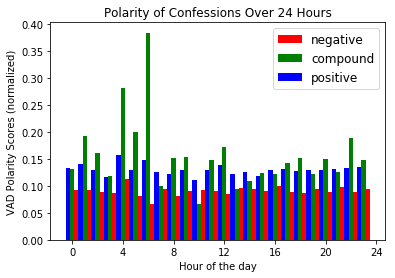

In [42]:
fig, ax = plt.subplots()
index = np.arange(24)
bar_width =0.5
w = 0.34
ax.bar(index+w, neg.values, width=w, color='r', align='center',label='negative')
# ax.bar(index-(w/2), neu.values, width=w, color='y', align='center')
ax.bar(index, compound.values, width=w, color='g', align='center',label='compound')
ax.bar(index-w, pos.values, width=w, color='b', align='center',label='positive')

# ax.bar(list(weekday_distri.index))
ax.grid(False)
# ax.set_xticklabels(np.arange(24))
plt.ylabel("VAD Polarity Scores (normalized)")
plt.xlabel("Hour of the day")
plt.xticks(np.arange(0,25, step=4))

# ax.grid(False)
# plt.xticks(index,list(compound.index))

plt.title('Polarity of Confessions Over 24 Hours')
plt.legend(loc=1, prop={'size':12 })
# plt.xticks(np.arange(12), calendar.month_name[1:13], rotation=20)
fig.savefig("weekday_nltk_vader.png")
plt.show()

## Filter DataFrame for detailed analysis

### Compute statistics

In [44]:
avg_valence = df[['Valence']].mean(axis=0)
avg_arousal = df[['Arousal']].mean(axis=0)
avg_dominance = df[['Dominance']].mean(axis=0)
print(avg_valence,avg_arousal,avg_dominance)

avg_compound = df[['compound']].mean(axis=0)
avg_pos = df[['pos']].mean(axis=0)

Valence    10.798588
dtype: float64 Arousal    11.119943
dtype: float64 Dominance    10.946375
dtype: float64


In [45]:
# df_neg = df[df['Dominance'] > avg_dominance[0]/2]
df_FULL_neg = df[df['compound'] < 0]
# df_neg= df_neg[df_neg['Valence'] < avg_valence[0]]
# df_neg = df_neg[df_neg['#NEG'] > 0]

In [46]:
df_FULL_pos = df[df['compound'] > 0.5]

In [48]:
df_FULL_pos.to_csv(r'/Users/tyler/UCSD_Wellness/analysis/df_FULL_pos_filters.csv',index=False)

In [49]:
# test = pd.read_csv('df_neg_filters.csv')
# test.head()

In [50]:
df_pos_by_compound = df[df['pos'] > avg_pos[0] ]
df_pos= df_pos_by_compound[df_pos_by_compound['Valence'] > avg_valence[0]]
df_pos = df_pos[df_pos['#POS'] > 3]

In [51]:
len(df_pos)

918

In [52]:
df_pos.to_csv(r'/Users/tyler/UCSD_Wellness/analysis/df_pos_filters.csv',index=False)

# Train Word2Vec Model

In [53]:
from gensim.models.word2vec import LineSentence
from nltk.corpus import subjectivity
nltk.download('vader_lexicon')
# first, we import the relevant modules from the NLTK library
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tyler/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [54]:
def train_word2vec(csv_filename_string, num_f, min_wc, ctxt,ds):   
    
    start = time.time();
    #Set the logging format to get some basic updates.
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
        level=logging.INFO)
    # Set values for various parameters
    num_features = num_f;    # Dimensionality of the hidden layer representation
    min_word_count = min_wc;   # Minimum word count to keep a word in the vocabulary
    num_workers = multiprocessing.cpu_count();       # Number of threads to run in parallel set to total number of cpus.
    context = ctxt       # Context window size (on each side)                                                       
    downsampling = ds   # Downsample setting for frequent words
    # Initialize and train the model. 
    #The LineSentence object allows us to pass in a file name directly as input to Word2Vec,
    #instead of having to read it into memory first.
    print("Training model...");
    model = word2vec.Word2Vec(LineSentence(csv_filename_string), workers=num_workers, \
                size=num_features, min_count = min_word_count, \
                window = context, sample = downsampling);
    # We don't plan on training the model any further, so calling 
    # init_sims will make the model more memory efficient by normalizing the vectors in-place.
    model.init_sims(replace=True);
    # Save the model
    model_name = "model_"+str(csv_filename_string);
    model.save(model_name);
    print('Total time: ' + str((time.time() - start)) + ' secs')
    return model

In [55]:
num_features = 100    # Dimensionality of the hidden layer representation
min_word_count = 35
context = 8
downsampling = 1e-3
model = train_word2vec('extra_clean_comments.csv', num_features,min_word_count,context,downsampling)

2019-12-06 11:47:25,216 : INFO : collecting all words and their counts
2019-12-06 11:47:25,217 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-12-06 11:47:25,406 : INFO : collected 22487 word types from a corpus of 562667 raw words and 8215 sentences
2019-12-06 11:47:25,406 : INFO : Loading a fresh vocabulary
2019-12-06 11:47:25,416 : INFO : effective_min_count=35 retains 1341 unique words (5% of original 22487, drops 21146)
2019-12-06 11:47:25,417 : INFO : effective_min_count=35 leaves 485939 word corpus (86% of original 562667, drops 76728)


Training model...


2019-12-06 11:47:25,421 : INFO : deleting the raw counts dictionary of 22487 items
2019-12-06 11:47:25,423 : INFO : sample=0.001 downsamples 70 most-common words
2019-12-06 11:47:25,424 : INFO : downsampling leaves estimated 323394 word corpus (66.6% of prior 485939)
2019-12-06 11:47:25,427 : INFO : estimated required memory for 1341 words and 100 dimensions: 1743300 bytes
2019-12-06 11:47:25,428 : INFO : resetting layer weights
2019-12-06 11:47:25,447 : INFO : training model with 8 workers on 1341 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=8
2019-12-06 11:47:25,699 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-12-06 11:47:25,706 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-12-06 11:47:25,707 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-12-06 11:47:25,708 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-12-06 11:47:25,708 : INFO : worker thread finishe

Total time: 1.5626611709594727 secs


In [56]:
Z = model.wv.syn0;
print(Z[0].shape)
Z[0]

(100,)


/Users/tyler/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


array([-1.68950975e-01,  3.79101895e-02,  8.61219130e-03, -7.03458041e-02,
       -1.14694685e-01,  3.62174027e-02, -1.82020098e-01, -4.76797903e-03,
        1.35690868e-01,  5.57781458e-02, -1.79503560e-02, -5.77451289e-03,
        2.62230486e-01,  1.26989260e-01, -8.88359025e-02, -3.24061513e-02,
       -9.99499038e-02, -2.44006217e-01,  1.11264147e-01,  4.30764966e-02,
       -1.61791131e-01,  5.55378608e-02,  9.96392965e-02,  9.81968828e-03,
        5.67640327e-02, -3.49691585e-02, -1.60246298e-01, -2.07538791e-02,
        6.62762579e-03,  7.02528208e-02,  7.66078234e-02,  2.35944651e-02,
       -9.91347209e-02,  3.41677926e-02,  1.97287500e-02,  4.75582819e-05,
        2.03056540e-02, -2.62740403e-01, -8.53961855e-02,  2.63546240e-02,
        1.17771983e-01,  8.85428637e-02, -7.40201697e-02, -1.41398013e-01,
        2.28702184e-02, -5.21110706e-02,  9.27993059e-02,  2.09717691e-01,
        4.95093688e-02, -5.11438726e-03, -1.75782993e-01, -9.46210623e-02,
       -1.37413844e-01, -

# Cluster, Generate Word Clouds

In [57]:
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx;

In [58]:
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);
#Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];
#Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i)] = [index2word[j] for j in closest_words_idxs[i][0]]
#A DataFrame is generated from the dictionary.
    print(closest_words['Cluster #0'])
    df = pd.DataFrame(closest_words);
    df.index = df.index+1
    return df;

In [59]:
def display_cloud(cluster_num, cmap, label=None):
#     print(cluster_num)
    wc = WordCloud(background_color="white", max_words=200, max_font_size=80, colormap=cmap);
    wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_num)]]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(label+ '_cluster_' + str(cluster_num), bbox_inches='tight')

In [60]:
centers, clusters = clustering_on_wordvecs(Z, 1);
centroid_map = dict(zip(model.wv.index2word, clusters));
top_words = get_top_words(model.wv.index2word, 30, centers, Z);


# temp = list(top_words['Cluster #0']).remove('sometimes')
# print(temp)

['death', 'offer', "friends']", 'freaking', 'speaking', 'pressure', "shit']", 'struggle', 'instagram', 'smoke', 'follow', 'holding', 'dreams', "lmao']", 'photos', 'clear', "['honestly", 'chances', 'killing', 'nut', 'plus', 'research', 'negative', 'stuck', "all']", 'near', 'lesbian', "time']", 'hearing', 'pictures']


/Users/tyler/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:276: RuntimeWarning: invalid value encountered in maximum
  np.maximum(distances, 0, out=distances)
/Users/tyler/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:625: RuntimeWarning: invalid value encountered in multiply
  inertia = (mindist * sample_weight).sum()
/Users/tyler/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:276: RuntimeWarning: invalid value encountered in maximum
  np.maximum(distances, 0, out=distances)
/Users/tyler/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:625: RuntimeWarning: invalid value encountered in multiply
  inertia = (mindist * sample_weight).sum()
/Users/tyler/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:276: RuntimeWarning: invalid value encountered in maximum
  np.maximum(distances, 0, out=distances)
/Users/tyler/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:276: RuntimeWarning:

In [61]:
# 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
#             'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
#             'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'

rainbow


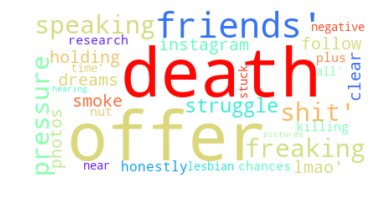

In [62]:
cmaps = 'rainbow'
for i in range(1):
    col = cmaps;
    print(col)
    display_cloud(i, col, label='total')

# Analyze Word Similarities

In [63]:
def get_word_table(table, key, sim_key='similarity', show_sim = True):
    if show_sim == True:
        return pd.DataFrame(table, columns=[key, sim_key])
    else:
        return pd.DataFrame(table, columns=[key, sim_key])[key]

In [64]:

keys = ['stressed','sad','relationship','school' ];
tables = [];
for key in keys:
    tables.append(get_word_table(model.wv.similar_by_word(key), key, show_sim=False))

In [65]:
similarity_table = pd.concat(tables, axis=1)


In [66]:
similarity_table

,stressed,sad,relationship,school
0,anxious,bad,fwb,high
1,frustrated,insecure,boyfriend,classes
2,healthy,awkward,sex,college
3,boring,feeling,dream,gpa
4,excited,worried,feelings,year
5,guilty,guilty,girlfriend,quarter
6,difficult,happy,ready,depression
7,tbh,depressed,bit,anxiety
8,negative,really,feeling,fall
9,confused,shy,friend,mental


In [67]:
similarity_table.to_csv(r'/Users/tyler/UCSD_Wellness/analysis/Final_total_similarity_sample.csv',index=False)

In [90]:

def compute_similarity_scores(confession, tags):
    """""
     
     :param confession: message to compute similarities to tags
     :type confession: str
     :param tags: keywords for comparison
     :type tags: list of str
     :returns: dictionary of array len(tags)
     """
    assert isinstance(confession, str)
    assert isinstance(tags, list)
    similarity_scores = {}
    words = confession.split()

    for i, word in enumerate(words):
    #         print(word)
    #         if str(word) not in model.wv.vocab:
    #             words = words.remove(word)
    #             print(confession)

        try:
            sim = [model.wv.similarity(str(word),tag) for tag in tags]
            similarity_scores[i] = sim
        except:
#             print('Error')
            similarity_scores[i] = list([0,0,0,0])
    
    return similarity_scores

        
    
#create dict for similarity scores of each word in the confession to each top_10 words for the tags

In [92]:
def generate_tag_suggestions(scores, tags):
    """""
     
     :param scores: similarities to  tags
     :type scores: dictionary
     :param tags: keywords for comparison
     :type tags: list of str
     :returns: dictionary of array len(tags)
     """
    assert isinstance(scores,dict)
    assert isinstance(tags,list)
    
    results = []
    for key, value in similarity_scores.items():
        for i, sim in enumerate(value):
             if sim > 0.75:
                results.append(tags[i])
                
    return results
        

# Proof of Concept: Auto-Tag Suggestion

### computes similarities of all words in the confession to every tag, thresholds to select candidates

In [97]:
## Define tags, load in new confession to be tagged.
tags = ['stressed','sad','relationship','school' ]
confession = "I am having a really rough day, my girl just dumped with me, AND I failed an exam."

In [98]:
similarity_scores = compute_similarity_scores(confession, tags)
suggest_tags = generate_tag_suggestions(similarity_scores, tags)
print(suggest_tags)

['sad']
